## Sebastian Petrik Abstractive Summarization Experiment 2
## Seq2seq with advanced preparation

- Adapted from https://github.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/tree/master/natural_language_processing
- Article: https://towardsdatascience.com/text-summarization-with-nlp-textrank-vs-seq2seq-vs-bart-474943efeb09

# Setup

### Session init

In [5]:
import os

# detect Colab
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  from google.colab import drive
  drive.mount('/content/drive/')
  %cd /content/drive/My Drive/PietroSum
else:
  print('Not running on CoLab')

# detect Vast.AI
if 'VAST_CONTAINERLABEL' in os.environ:
  print('Running in Vast.AI')

# import sys
# import os
# py_file_location = "/content/drive/My Drive/PietroSum"
# sys.path.append(os.path.abspath(py_file_location))

Not running on CoLab
Running in Vast.AI


### Libraries

In [6]:
## data
%pip install numpy pandas xlrd
## plot
%pip install matplotlib seaborn
## machine learning
%pip install scikit-learn lime
## deep learning
%pip install tensorflow shap
## nlp
%pip install nltk spacy gensim wordcloud langdetect textblob transformers rouge contractions langdetect

     |████████████████████████████████| 12.2 MB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 12.0 MB/s  eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 9.4 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 293 kB 117.4 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 85.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 54.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 124.7 MB/s eta 0:00:01
     |████████████████████████████████| 300 kB 98.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 9.8 MB 15.6 MB/s eta 0:00:01
     |████████████████████████████████| 275 kB 100.6 M

### Library importing

In [7]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import langdetect 
import nltk
import wordcloud
import contractions
import spacy
import collections
from tensorflow import keras
from tensorflow.keras import backend as K
from lime import lime_text
import shap
import gensim
import gensim.downloader
import transformers
import rouge
import difflib
from IPython.core.display import display, HTML

2023-01-27 08:06:55.125664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Library data loading

In [8]:
nltk.download(['stopwords', 'wordnet', 'omw-1.4', 'punkt']) # nltk stuff we need

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Dataset loading

In [9]:
# Direct full cnn:
#import datasets
#dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

#lst_dics = [dic for dic in dataset["train"]]
#dtf = pd.DataFrame(lst_dics).rename(columns={"article":"text", "highlights":"y"})[["text","y"]].head(20000)
#dtf.to_csv("data_summary.csv", index=False)
#dtf.head()

In [10]:
df_raw = pd.read_csv("data_summary.csv") # mounted
df_raw.head()

,Unnamed: 0,text,y
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...


### Visualisation setup

In [11]:
'''
Find the matching substrings in 2 strings.
:parameter
    :param a: string - raw text
    :param b: string - raw text
:return
    2 lists used in to display matches
'''
def utils_split_sentences(a, b):
    ## find clean matches
    match = difflib.SequenceMatcher(isjunk=None, a=a, b=b, autojunk=True)
    lst_match = [block for block in match.get_matching_blocks() if block.size > 20]
    
    ## difflib didn't find any match
    if len(lst_match) == 0:
        lst_a, lst_b = nltk.sent_tokenize(a), nltk.sent_tokenize(b)
    
    ## work with matches
    else:
        first_m, last_m = lst_match[0], lst_match[-1]

        ### a
        string = a[0 : first_m.a]
        lst_a = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = a[m.a : m.a+m.size]
            lst_a.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = a[m.a+m.size : next_m.a]
                lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = a[last_m.a+last_m.size :]
        lst_a = lst_a + [t for t in nltk.sent_tokenize(string)]

        ### b
        string = b[0 : first_m.b]
        lst_b = [t for t in nltk.sent_tokenize(string)]
        for n in range(len(lst_match)):
            m = lst_match[n]
            string = b[m.b : m.b+m.size]
            lst_b.append(string)
            if n+1 < len(lst_match):
                next_m = lst_match[n+1]
                string = b[m.b+m.size : next_m.b]
                lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
            else:
                break
        string = b[last_m.b+last_m.size :]
        lst_b = lst_b + [t for t in nltk.sent_tokenize(string)]
    
    return lst_a, lst_b

'''
Highlights the matched strings in text.
:parameter
    :param a: string - raw text
    :param b: string - raw text
    :param both: bool - search a in b and, if True, viceversa
    :param sentences: bool - if False matches single words
:return
    text html, it can be visualized on notebook with display(HTML(text))
'''
def display_string_matching(a, b, both=True, sentences=True, titles=[]):
    if sentences is True:
        lst_a, lst_b = utils_split_sentences(a, b)
    else:
        lst_a, lst_b = a.split(), b.split()       
    
    ## highlight a
    first_text = []
    for i in lst_a:
        if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_b]:
            first_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
        else:
            first_text.append(i)
    first_text = ' '.join(first_text)
    
    ## highlight b
    second_text = []
    if both is True:
        for i in lst_b:
            if re.sub(r'[^\w\s]', '', i.lower()) in [re.sub(r'[^\w\s]', '', z.lower()) for z in lst_a]:
                second_text.append('<span style="background-color:rgba(255,215,0,0.3);">' + i + '</span>')
            else:
                second_text.append(i)
    else:
        second_text.append(b) 
    second_text = ' '.join(second_text)
    
    ## concatenate
    if len(titles) > 0:
        first_text = "<strong>"+titles[0]+"</strong><br>"+first_text
    if len(titles) > 1:
        second_text = "<strong>"+titles[1]+"</strong><br>"+second_text
    else:
        second_text = "---"*65+"<br><br>"+second_text
    final_text = first_text +'<br><br>'+ second_text
    return final_text

In [12]:
display(HTML(display_string_matching(df_raw["text"][1], df_raw["y"][1])))

# Text preprocessing and cleaning

In [13]:
lst_stopwords = nltk.corpus.stopwords.words('english') + ["cnn","say","said","new","wa","ha"]
lst_stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

In [14]:
'''
Preprocess a string.
:parameter
    :param txt: string - name of column containing text
    :param lst_regex: list - list of regex to remove
    :param punkt: bool - if True removes punctuations and characters
    :param lower: bool - if True convert lowercase
    :param slang: bool - if True fix slang into normal words
    :param lst_stopwords: list - list of stopwords to remove
    :param stemm: bool - whether stemming is to be applied
    :param lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def preprocess_text(txt, lst_regex=None, punkt=True, lower=True, slang=True, lst_stopwords=None, stemm=False, lemm=True):
    ## Regex (in case, before cleaning)
    if lst_regex is not None: 
        for regex in lst_regex:
            txt = re.sub(regex, '', txt)

    ## Clean 
    ### separate sentences with '. '
    txt = re.sub(r'\.(?=[^ \W\d])', '. ', str(txt))
    ### remove punctuations and characters
    txt = re.sub(r'[^\w\s]', '', txt) if punkt is True else txt
    ### strip
    txt = " ".join([word.strip() for word in txt.split()])
    ### lowercase
    txt = txt.lower() if lower is True else txt
    ### slang
    txt = contractions.fix(txt) if slang is True else txt
            
    ## Tokenize (convert from string to list)
    lst_txt = txt.split()
                
    ## Stemming (remove -ing, -ly, ...)
    if stemm is True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_txt = [ps.stem(word) for word in lst_txt]
                
    ## Lemmatization (convert the word into root word)
    if lemm is True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_txt = [lem.lemmatize(word) for word in lst_txt]

    ## Stopwords
    if lst_stopwords is not None:
        lst_txt = [word for word in lst_txt if word not in lst_stopwords]
            
    ## Back to string
    txt = " ".join(lst_txt)
    return txt

In [15]:
'''
Adds a column of preprocessed text.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
:return
    : input dataframe with two new columns
'''
def add_preprocessed_text(data, column, lst_regex=None, punkt=False, lower=False, slang=False, lst_stopwords=None, stemm=False, lemm=False, remove_na=True):
    dtf = data.copy()

    ## apply preprocess
    dtf = dtf[ pd.notnull(dtf[column]) ]
    dtf[column+"_clean"] = dtf[column].apply(lambda x: preprocess_text(x, lst_regex, punkt, lower, slang, lst_stopwords, stemm, lemm))
    
    ## residuals
    dtf["check"] = dtf[column+"_clean"].apply(lambda x: len(x))
    if dtf["check"].min() == 0:
        print("--- found NAs ---")
        print(dtf[[column,column+"_clean"]][dtf["check"]==0].head())
        if remove_na is True:
            dtf = dtf[dtf["check"]>0] 
            
    return dtf.drop("check", axis=1)

In [16]:
# proprocess text into separate columns
df_pre = add_preprocessed_text(df_raw, column="text", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
df_pre = add_preprocessed_text(df_pre, column="y", 
                            punkt=True, lower=True, slang=True, lst_stopwords=lst_stopwords, lemm=True)
df_pre.head()

,Unnamed: 0,text,y,text_clean,y_clean
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,official president barack obama want lawmaker ...,syrian official obama climbed top tree doe kno...
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,usain bolt rounded world championship sunday c...,usain bolt win third gold world championship a...
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,kansa city missouri general service administra...,employee agency kansa city office among hundre...
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,los angeles medical doctor vancouver british c...,canadian doctor part team examining harry burk...
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...


In [17]:
display(HTML(display_string_matching(df_pre["text_clean"][1], df_pre["y_clean"][1])))

### Word frequency analysis

In [18]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(corpus, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = dtf_freq.append(dtf_n)
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')["ngrams","freq","word"].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

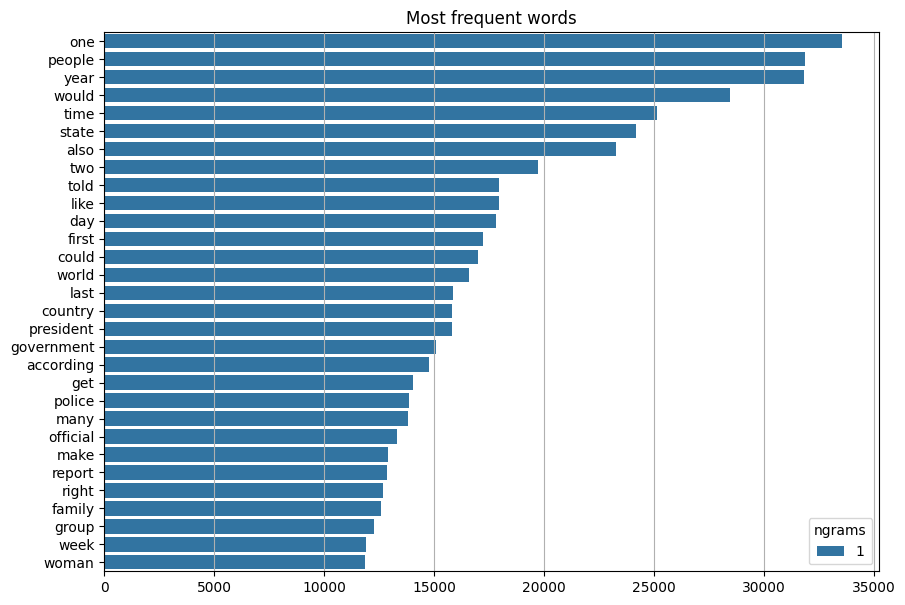

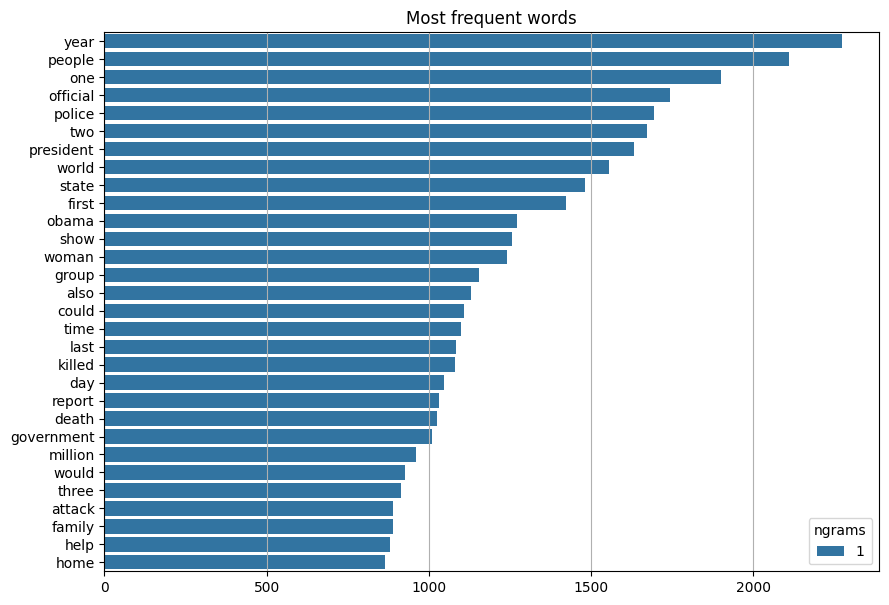

(42997, 10245)

In [19]:
# Find most common words in text

threshold = 5
df_freq = word_freq(corpus=df_pre["text_clean"], ngrams=[1], top=30, figsize=(10,7))
X_top_words = len(df_freq[df_freq["freq"]>threshold]) # get only above threshold

df_freq = word_freq(corpus=df_pre["y_clean"], ngrams=[1], top=30, figsize=(10,7))
y_top_words = len(df_freq[df_freq["freq"]>threshold])

(X_top_words, y_top_words)

### Sequence length analysis

In [20]:
'''
Compute different text length metrics.
:parameter
    :param dtf: dataframe - dtf with a text column
    :param column: string - name of column containing text
:return
    dtf: input dataframe with 2 new columns
'''
def add_text_length(data, column):
    dtf = data.copy()
    dtf['word_count'] = dtf[column].apply(lambda x: len(nltk.word_tokenize(str(x))) )
    dtf['char_count'] = dtf[column].apply(lambda x: sum(len(word) for word in nltk.word_tokenize(str(x))) )
    dtf['sentence_count'] = dtf[column].apply(lambda x: len(nltk.sent_tokenize(str(x))) )
    dtf['avg_word_length'] = dtf['char_count'] / dtf['word_count']
    dtf['avg_sentence_lenght'] = dtf['word_count'] / dtf['sentence_count']
    print(dtf[['char_count','word_count','sentence_count','avg_word_length','avg_sentence_lenght']].describe().T[["min","mean","max"]])
    return dtf

In [21]:
X = add_text_length(df_pre, "text_clean")
y = add_text_length(df_pre, "y_clean")

                            min         mean          max
char_count           103.000000  2260.120300  10038.00000
word_count            19.000000   363.755600   1309.00000
sentence_count         1.000000     1.000000      1.00000
avg_word_length        3.992945     6.210552     35.34507
avg_sentence_lenght   19.000000   363.755600   1309.00000
                       min        mean    max
char_count           35.00  164.703400  319.0
word_count            4.00   27.015400   50.0
sentence_count        1.00    1.000000    1.0
avg_word_length       4.15    6.117243   10.0
avg_sentence_lenght   4.00   27.015400   50.0


In [22]:
'''
Plot univariate and bivariate distributions.
'''
def plot_distributions(dtf, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    ## univariate
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        ### categorical
        if dtf[x].nunique() <= max_cat:
            if top is None:
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        ### numerical
        else:
            sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    ## bivariate
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

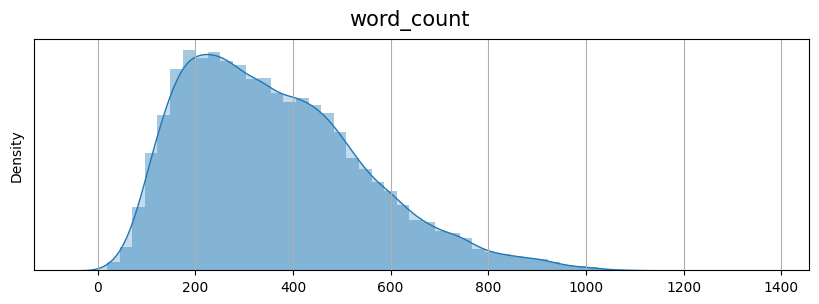

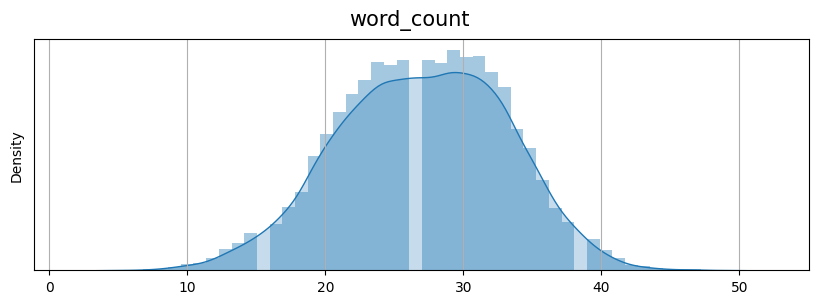

In [23]:
plot_distributions(X, x="word_count", figsize=(10,3))
plot_distributions(y, x="word_count", max_cat=1, figsize=(10,3))

In [24]:
# set maximum sequence length based on dist
X_len = 400
y_len = 40

# Train and test set split

In [25]:
test_len = 10
df_train = df_pre.iloc[test_len+1:].copy()
df_test = df_pre.iloc[:test_len+1].copy()
df_test

,Unnamed: 0,text,y,text_clean,y_clean
0,0,It's official: U.S. President Barack Obama wan...,Syrian official: Obama climbed to the top of t...,official president barack obama want lawmaker ...,syrian official obama climbed top tree doe kno...
1,1,(CNN) -- Usain Bolt rounded off the world cham...,Usain Bolt wins third gold of world championsh...,usain bolt rounded world championship sunday c...,usain bolt win third gold world championship a...
2,2,"Kansas City, Missouri (CNN) -- The General Ser...",The employee in agency's Kansas City office is...,kansa city missouri general service administra...,employee agency kansa city office among hundre...
3,3,Los Angeles (CNN) -- A medical doctor in Vanco...,NEW: A Canadian doctor says she was part of a ...,los angeles medical doctor vancouver british c...,canadian doctor part team examining harry burk...
4,4,(CNN) -- Police arrested another teen Thursday...,Another arrest made in gang rape outside Calif...,police arrested another teen thursday sixth su...,another arrest made gang rape outside californ...
5,5,(CNN) -- Thousands on Saturday fled the area i...,"Humanitarian groups expect 4,000 refugees in o...",thousand saturday fled area southwestern ivory...,humanitarian group expect 4000 refugee one cam...
6,6,(CNN) -- Four groups that advocate for immigra...,NEW: 4 groups announce legal challenge in Phoe...,four group advocate immigrant right thursday c...,4 group announce legal challenge phoenix ameri...
7,7,While Labor Day is the unofficial end of summe...,Labor Day is the unofficial end of summer and ...,labor day unofficial end summer also unofficia...,labor day unofficial end summer unofficial sta...
8,8,Gaza City (CNN) -- An Italian humanitarian act...,NEW: Autopsy indicates he had been dead for ho...,gaza city italian humanitarian activist journa...,autopsy indicates dead hour police arrived you...
9,9,(CNN) -- Renowned radio personality Casey Kase...,The radio personality was taken to a hospital ...,renowned radio personality casey kasem critica...,radio personality taken hospital sunday spokes...


# Feature engineering

### Tokenization

In [26]:
'''
Create a list of lists of grams with gensim:
    [ ["hi", "my", "name", "is", "Tom"], 
      ["what", "is", "yours"] ]
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
:return
    lst of lists of n-grams
'''
def utils_preprocess_ngrams(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[]):
    ## create list of n-grams
    lst_corpus = []
    for string in corpus:
        lst_words = string.split()
        lst_grams = [grams_join.join(lst_words[i:i + ngrams]) for i in range(0, len(lst_words), ngrams)]
        lst_corpus.append(lst_grams)
    
    ## detect common bi-grams and tri-grams
    if len(lst_ngrams_detectors) != 0:
        for detector in lst_ngrams_detectors:
            lst_corpus = list(detector[lst_corpus])
    return lst_corpus

In [27]:
'''
Transforms the corpus into an array of sequences of idx (tokenizer) with same length (padding).
:parameter
    :param corpus: list - dtf["text"]
    :param ngrams: num - ex. "new", "york"
    :param grams_join: string - "_" (new_york), " " (new york)
    :param lst_ngrams_detectors: list - [bigram and trigram models], if empty doesn't detect common n-grams
    :param fitted_tokenizer: keras tokenizer - if None it creates one with fit and transorm (train set), if given it transforms only (test set)
    :param top: num - if given the tokenizer keeps only top important words
    :param oov: string - how to encode words not in vocabulary (ex. "NAN")
    :param maxlen: num - dimensionality of the vectors, if None takes the max length in corpus
    :param padding: string - <PAD> token
:return
    If training: matrix of sequences, tokenizer, dic_vocabulary. Else matrix of sequences only.
'''
def text2seq(corpus, ngrams=1, grams_join=" ", lst_ngrams_detectors=[], fitted_tokenizer=None, top=None, oov=None, maxlen=None, padding="<PAD>"):    
    print("--- tokenization ---")
    
    ## detect common n-grams in corpus
    lst_corpus = utils_preprocess_ngrams(corpus, ngrams=ngrams, grams_join=grams_join, lst_ngrams_detectors=lst_ngrams_detectors)

    ## bow with keras to get text2tokens without creating the sparse matrix
    ### train
    if fitted_tokenizer is None:
        tokenizer = keras.preprocessing.text.Tokenizer(num_words=top, lower=False, split=' ', char_level=False, oov_token=oov,
                                               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
        tokenizer.fit_on_texts(lst_corpus)
        dic_vocabulary = {padding:0}
        words = tokenizer.word_index if top is None else dict(list(tokenizer.word_index.items())[0:top+1])
        dic_vocabulary.update(words)
        print(len(dic_vocabulary), "words")
    else:
        tokenizer = fitted_tokenizer
    ### transform
    lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

    ## padding sequence (from [1,2],[3,4,5,6] to [0,0,1,2],[3,4,5,6])
    print("--- padding to sequence ---")
    X = keras.preprocessing.sequence.pad_sequences(lst_text2seq, maxlen=maxlen, padding="post", truncating="post")
    print(X.shape[0], "sequences of length", X.shape[1]) 

    ## plot heatmap
    fig, ax = plt.subplots(figsize=(15,5))
    sns.heatmap(X==0, vmin=0, vmax=1, cbar=False, ax=ax).set_title('Sequences Overview')
    plt.show()
    return (X, tokenizer, dic_vocabulary) if fitted_tokenizer is None else X

Text (X) tokenization:

--- tokenization ---
42999 words
--- padding to sequence ---
19989 sequences of length 400


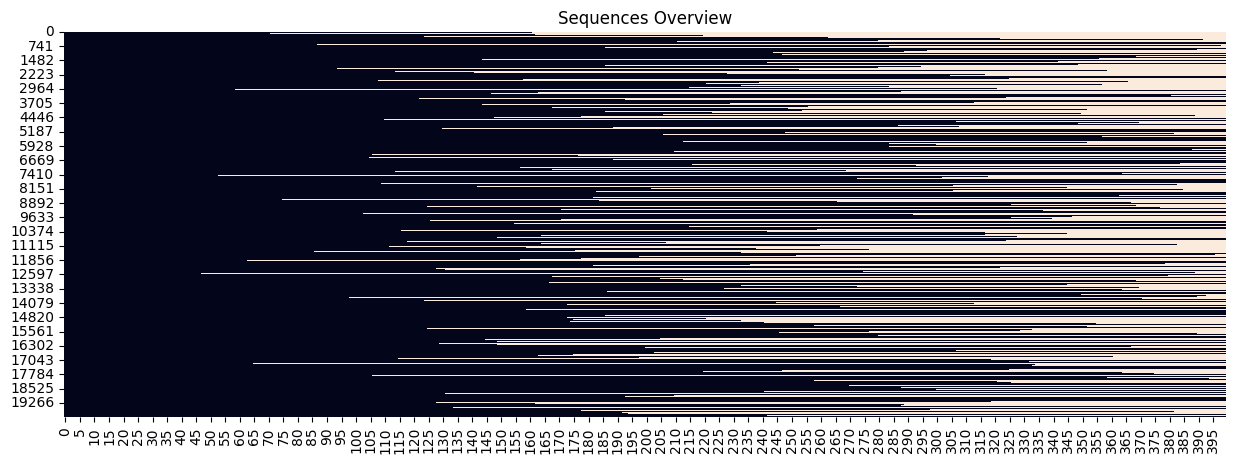

--- tokenization ---
--- padding to sequence ---
11 sequences of length 400


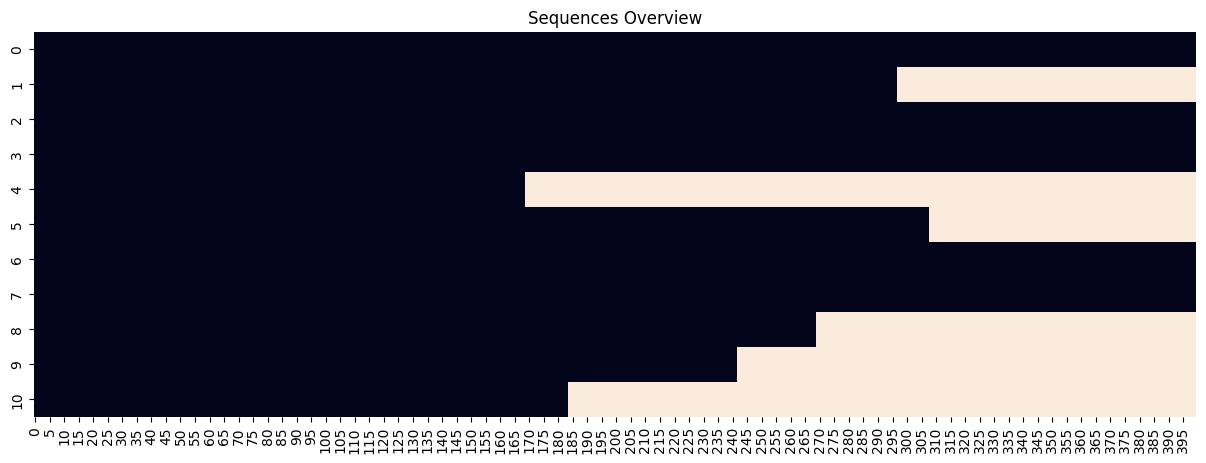

In [28]:
# Tokenize X on train set
X_train, X_tokenizer, X_vocabulary = text2seq(corpus=df_train["text_clean"], top=X_top_words, maxlen=X_len)
# Tokenize X on test set using train set tokenizer
X_test = text2seq(corpus=df_test["text_clean"], fitted_tokenizer=X_tokenizer, maxlen=X_train.shape[1])

In [29]:
dict(list(X_vocabulary.items())[0:6])

{'<PAD>': 0, 'one': 1, 'people': 2, 'year': 3, 'would': 4, 'time': 5}

Summary (y) tokenization:

In [30]:
# Add START and END tokens to the summaries (y)
special_tokens = ("<START>", "<END>")
df_train["y_clean"] = df_train['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
df_test["y_clean"] = df_test['y_clean'].apply(lambda x: special_tokens[0]+' '+x+' '+special_tokens[1])
df_test["y_clean"][1]

'<START> usain bolt win third gold world championship anchor jamaica 4x100m relay victory eighth gold championship bolt jamaica double woman 4x100m relay <END>'

--- tokenization ---
10247 words
--- padding to sequence ---
19989 sequences of length 40


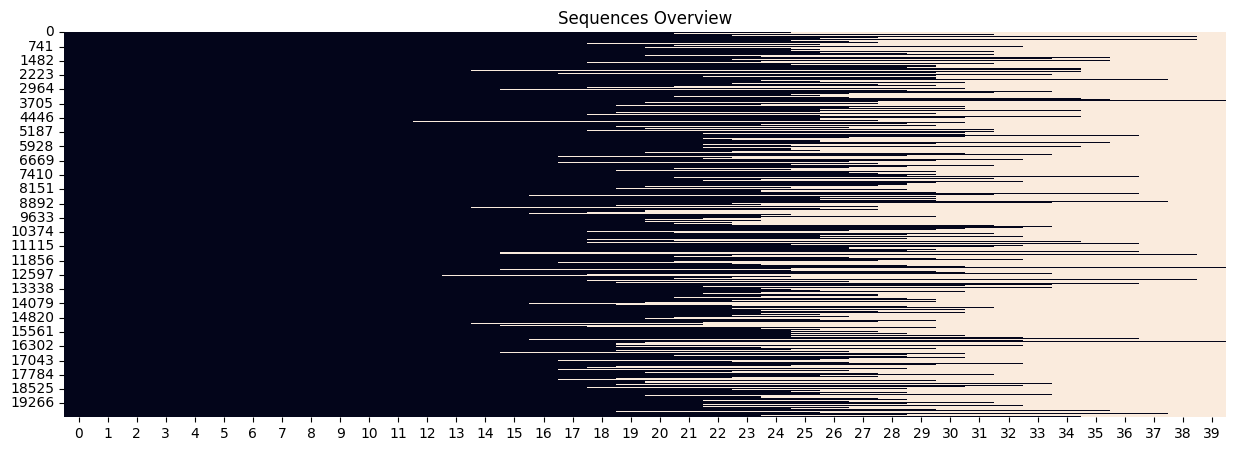

--- tokenization ---
--- padding to sequence ---
11 sequences of length 40


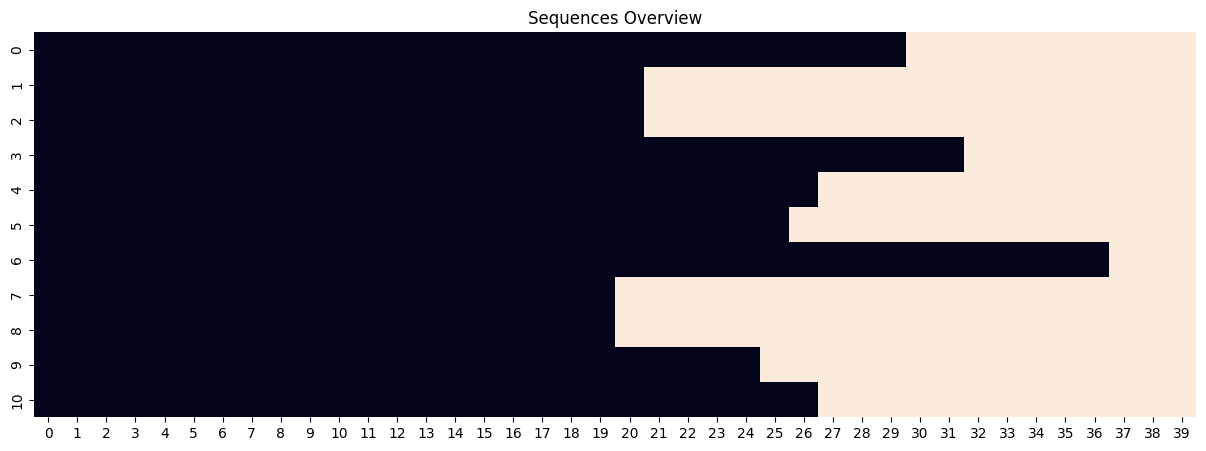

In [31]:
# Tokenize y on train set 
y_train, y_tokenizer, y_vocabulary = text2seq(corpus=df_train["y_clean"], top=y_top_words, maxlen=y_len)
# Tokenize y on test set with train set tokenizer
y_test = text2seq(corpus=df_test["y_clean"], fitted_tokenizer=y_tokenizer, maxlen=y_train.shape[1])

## Word embeddings

In [47]:
# Load pre-trained Word2Vec
glove_vectors = gensim.downloader.load("glove-wiki-gigaword-300")

# Or train Word2Vec from scratch
#corpus =  dtf_train["text_clean"].append(dtf_train["y_clean"])
#lst_corpus, nlp = fit_w2v(corpus=corpus, min_count=1, size=300, window=y_avg_len)

In [49]:
'''
Embeds a vocabulary of unigrams with gensim w2v.
:parameter
    :param dic_vocabulary: dict - {"word":1, "word":2, ...}
    :param nlp: gensim model
:return
    Matric and the nlp model
'''
def vocabulary_embeddings(dic_vocabulary, nlp=None):
    nlp = gensim.downloader.load("glove-wiki-gigaword-300") if nlp is None else nlp
    embeddings = np.zeros((len(dic_vocabulary)+1, nlp.vector_size))
    for word,idx in dic_vocabulary.items():
        ## update the row with vector
        try:
            embeddings[idx] =  nlp[word]
        ## if word not in model then skip and the row stays all zeros
        except:
            pass
    print("vocabulary mapped to", embeddings.shape[0], "vectors of size", embeddings.shape[1])
    return embeddings


In [50]:
# setup embedding weights
X_embeddings = vocabulary_embeddings(X_vocabulary, glove_vectors)
X_embeddings.shape

vocabulary mapped to 43000 vectors of size 300


(43000, 300)

In [52]:
y_embeddings = vocabulary_embeddings(y_vocabulary, glove_vectors)
y_embeddings.shape

vocabulary mapped to 10248 vectors of size 300


(10248, 300)

# Seq2seq model implementation

Example of basic seq2seq model, 1 unidirectional LSTM layer, Embedding layer without pretrained embeddings

In [53]:
# Basic Seq2Seq
# lstm_units = 250
# embeddings_size = 300

# ##------------ ENCODER (embeddings + lstm) -----------------------------##
# x_in = layers.Input(name="x_in", shape=(X_train.shape[1],))
# ### embedding
# layer_x_emb = layers.Embedding(name="x_emb", input_dim=len(X_dic_vocabulary), output_dim=embeddings_size, 
#                                trainable=True)
# x_emb = layer_x_emb(x_in)
# ### lstm 
# layer_x_lstm = layers.LSTM(name="x_lstm", units=lstm_units, dropout=0.4,  
#                            return_sequences=True, return_state=True)
# x_out, state_h, state_c = layer_x_lstm(x_emb)

# ##------------ DECODER (embeddings + lstm + dense) ---------------------##
# y_in = layers.Input(name="y_in", shape=(None,))
# ### embedding
# layer_y_emb = layers.Embedding(name="y_emb", input_dim=len(y_dic_vocabulary), output_dim=embeddings_size, 
#                                trainable=True)
# y_emb = layer_y_emb(y_in)
# ### lstm 
# layer_y_lstm = layers.LSTM(name="y_lstm", units=lstm_units, dropout=0.4,
#                            return_sequences=True, return_state=True)
# y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
# ### final dense layers
# layer_dense = layers.TimeDistributed(name="dense", 
#                                      layer=layers.Dense(units=len(y_dic_vocabulary), activation='softmax'))
# y_out = layer_dense(y_out)

# ##---------------------------- COMPILE --------------------------------##
# model = models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
# model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()

Advanced model, 3 bidirectional LSTM layers, pretrained embedding using GloVe:


TODO: Enable cudnn perhaps with recurrent dropout ? https://stackoverflow.com/questions/68844792/lstm-will-not-use-cudnn-kernels-since-it-doesnt-meet-the-criteria-it-will-use

In [54]:
# Advanced Seq2Seq
lstm_units = 250

##------------ ENCODER (pre-trained embeddings + 3 bi-lstm) ---------------##
x_in = keras.layers.Input(name="x_in", shape=(X_train.shape[1],))
### embedding
layer_x_emb = keras.layers.Embedding(name="x_emb", input_dim=X_embeddings.shape[0], output_dim=X_embeddings.shape[1], 
                               weights=[X_embeddings], trainable=False)
x_emb = layer_x_emb(x_in)
### bi-lstm 1
layer_x_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True), 
                                      name="x_lstm_1")
x_out, _, _, _, _ = layer_x_bilstm(x_emb)
### bi-lstm 2
layer_x_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4,
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_2")
x_out, _, _, _, _ = layer_x_bilstm(x_out)
### bi-lstm 3 (here final states are collected)
layer_x_bilstm = keras.layers.Bidirectional(keras.layers.LSTM(units=lstm_units, dropout=0.4, recurrent_dropout=0.4, 
                                                  return_sequences=True, return_state=True),
                                      name="x_lstm_3")
x_out, forward_h, forward_c, backward_h, backward_c = layer_x_bilstm(x_out)
state_h = keras.layers.Concatenate()([forward_h, backward_h])
state_c = keras.layers.Concatenate()([forward_c, backward_c])

##------------ DECODER (pre-trained embeddings + lstm + dense) ------------##
y_in = keras.layers.Input(name="y_in", shape=(None,))
### embedding
layer_y_emb = keras.layers.Embedding(name="y_emb", input_dim=y_embeddings.shape[0], output_dim=y_embeddings.shape[1], 
                               weights=[y_embeddings], trainable=False)
y_emb = layer_y_emb(y_in)
### lstm
layer_y_lstm = keras.layers.LSTM(name="y_lstm", units=lstm_units*2, dropout=0.2, recurrent_dropout=0.2,
                           return_sequences=True, return_state=True)
y_out, _, _ = layer_y_lstm(y_emb, initial_state=[state_h, state_c])
### final dense layers
layer_dense = keras.layers.TimeDistributed(name="dense", 
                                     layer=keras.layers.Dense(units=len(y_vocabulary), activation='softmax'))
y_out = layer_dense(y_out)

##---------------------------- COMPILE ------------------------------------##
model = keras.models.Model(inputs=[x_in, y_in], outputs=y_out, name="Seq2Seq")
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

model.summary()

Model: "Seq2Seq"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 400)]        0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 400, 300)     12900000    ['x_in[0][0]']                   
                                                                                                  
 x_lstm_1 (Bidirectional)       [(None, 400, 500),   1102000     ['x_emb[0][0]']                  
                                 (None, 250),                                                     
                                 (None, 250),                                                     
                                 (None, 250),                                               

# Model training

In [55]:
def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))
    
    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()
    
    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

Load model if present

In [56]:
modeldir = 'model'
checkpoint_filepath = modeldir + '/checkpoint.hdf'
print('Target path:', checkpoint_filepath)

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

csv_logger=keras.callbacks.CSVLogger(modeldir + '/log.csv', separator=",", append=True)

try:
  model.load_weights(checkpoint_filepath)
  print('Loaded model weights checkpoint.')
except:
  print('Cannot load model weights from checkpoint, it may not exist yet.')

Target path: model/checkpoint.hdf
Loaded model weights checkpoint.


Start training:

In [57]:
TRAIN_ENABLED = False

epochs = 100
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

if TRAIN_ENABLED:
  print('Starting training...')
  training = model.fit(
      x=[X_train, y_train[:,:-1]],
      y=y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:],
      batch_size=200,
      epochs=epochs,
      shuffle=True,
      verbose=1,
      validation_split=0.3,
      callbacks=[early_stopping, model_checkpoint_callback, csv_logger]
  )



In [58]:
if TRAIN_ENABLED:
  utils_plot_keras_training(training)

# Model evaluation

### Prediction model

In [59]:
# Prediction Encoder
encoder_model = keras.models.Model(inputs=x_in, outputs=[x_out, state_h, state_c], name="Prediction_Encoder")
encoder_model.summary()

Model: "Prediction_Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_in (InputLayer)              [(None, 400)]        0           []                               
                                                                                                  
 x_emb (Embedding)              (None, 400, 300)     12900000    ['x_in[0][0]']                   
                                                                                                  
 x_lstm_1 (Bidirectional)       [(None, 400, 500),   1102000     ['x_emb[0][0]']                  
                                 (None, 250),                                                     
                                 (None, 250),                                                     
                                 (None, 250),                                    

In [60]:
# Prediction Decoder
## double the lstm units if you used bidirectional lstm
# lstm_units = lstm_units*2 if any("Bidirectional" in str(layer) for layer in model.layers) else lstm_units
lstm_units = 500

## states of the previous time step
x_out2 = keras.layers.Input(shape=(X_train.shape[1], lstm_units))
state_h, state_c = keras.layers.Input(shape=(lstm_units,)), keras.layers.Input(shape=(lstm_units,))

## decoder embeddings
y_emb2 = layer_y_emb(y_in)

## lstm to predict the next word
y_out2, new_state_h, new_state_c = layer_y_lstm(y_emb2, initial_state=[state_h, state_c])

## softmax to generate probability distribution over the target vocabulary
probs = layer_dense(y_out2)

## compile
decoder_model = keras.models.Model(inputs=[y_in, x_out2, state_h, state_c], 
                             outputs=[probs, new_state_h, new_state_c],
                             name="Prediction_Decoder")
decoder_model.summary()


Model: "Prediction_Decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 y_in (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 y_emb (Embedding)              (None, None, 300)    3074400     ['y_in[0][0]']                   
                                                                                                  
 input_5 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 500)]        0           []                               
                                                                                 

# Sequence prediction

In [61]:
'''
Predicts text sequences.
:parameter
    :param x: array - sequence of shape (n x max_seq_lenght)
    :param encoder_model: keras model - input: x
                                        output: [(1, max_seq_lenght, lstm_units), state_h, state_c]
    :param decoder_model: keras model - input: [1 word idx, encoder output, state_h (1 x lstm_units), state_c (1 x lstm_units)] 
                                        output: [probs, new_state_h, new_state_c]
    :param fitted_tokenizer: fitted tokenizer to convert predicted idx in words
    :param special_tokens: tuple - start-of-seq token and end-of-seq token
:return
    list of predicted text
'''
def predict_seq2seq(X_test, encoder_model, decoder_model, fitted_tokenizer, special_tokens=("<START>","<END>")):
    max_seq_lenght = X_test.shape[1]
    predicted = []
    for x in X_test:
        x = x.reshape(1,-1)

        ## encode X
        x_out, state_h, state_c = encoder_model.predict(x)

        ## prepare loop
        y_in = np.array([fitted_tokenizer.word_index[special_tokens[0]]])
        y_in2 = y_in.reshape(y_in.shape + (1,))
        
        predicted_text = ""
        stop = False

        while not stop:
            ## predict dictionary probability distribution
            probs, new_state_h, new_state_c = decoder_model.predict([y_in2, x_out, state_h, state_c])
            ## get predicted word
            
            voc_idx = np.argmax(probs[0,-1,:])
            
            pred_word = fitted_tokenizer.index_word[voc_idx]
            
            print(pred_word)
            
            ## check stop
            if (pred_word != special_tokens[1]) and (len(predicted_text.split()) < max_seq_lenght):
                predicted_text = predicted_text +" "+ pred_word
            else:
                stop = True
            ## next
            y_in = np.array([voc_idx])
            state_h, state_c = new_state_h, new_state_c

        predicted_text = predicted_text.replace(special_tokens[0],"").strip()
        predicted.append(predicted_text)

    return predicted

i = 7

print(df_test.loc[i, 'y_clean'])

# predict test set
predicted = predict_seq2seq(X_test[i:i+1], encoder_model, decoder_model, y_tokenizer, special_tokens)
predicted

<START> labor day unofficial end summer unofficial start campaign season much 34 billion could spent advertising midterm election five mustfollow race midterm <END>
1/1 [==============================] - 0s 184ms/step
republican
1/1 [==============================] - 0s 22ms/step
romney
1/1 [==============================] - 0s 21ms/step
campaign
1/1 [==============================] - 0s 21ms/step
campaign
1/1 [==============================] - 0s 21ms/step


KeyError: 0

In [64]:
'''
Summarizes corpus with Bart.
:parameter
    :param corpus: list - dtf["text"]
    :param max_len: length of the summary
:return
    list of summaries
'''
def bart_pipe(corpus, max_len):
    nlp = transformers.pipeline("summarization")
    lst_summaries = [nlp(txt[:max_len], max_length=max_len
                        )[0]["summary_text"].replace(" .", ".")
                     for txt in corpus]
    return lst_summaries

predicted = bart_pipe(corpus=df_test["text"], max_len=y_len)
predicted

No model was supplied, defaulted to t5-small and revision d769bba (https://huggingface.co/t5-small).
Using a pipeline without specifying a model name and revision in production is not recommended.


All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Your max_length is set to 40, but you input_length is only 16. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)
2023-01-27 08:19:04.392172: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x35b4c5d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-27 08:19:04.392214: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2023-01-27 08:19:04.398217: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-27 08:19:04.421899: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Your max_length is set to 40, but you input_length is only 20. You might consider decreasing max_length manually, e.g. summarizer('...', max_length=10)
Your max_length

["it's official: president obama's inauguration will be held in the u.s. on thursday.",
 'usain Bolt rounded off the worl. he is ranked second in the u.s. rankings.',
 'the Gener was born in the u.s. at the age of 18. he was a member of the olympics.',
 'a medical doctor in los angeles is a doctor in the u.s. he has been in the medical field for a few years.',
 'another teen is arrested by police. he was arrested on suspicion of aggravated burglary. the teen was a teen in the u.s.',
 "Thousands of people flee the city on saturday. cnn's john mccain says he's not the only one.",
 'four groups advocate for iraq. group: iran, syria, egypt, u.s..',
 "Während Labor Day is the unofficial end of the year, there are no official deadlines for the end of this year's Labor Day.",
 'an italian humanitarism is the most important humanitarian humanitarianism in the world. it is the largest humanitar organization in the u.s.',
 'radio personality Casey is a renommated radio personality. he was a memb